<a href="https://colab.research.google.com/github/wjsdydan-bit/fate-scent/blob/main/%EC%82%AC%EC%A3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ 한글 폰트 설치 중... (약 10초 소요)
✅ 폰트 설정 완료!

📂 파일 존재 확인
 - 로그: True /recommendation_logs (3).csv
 - 설문: True /설문조사(1차 16명).xlsx

[데이터 크기]
 - 로그: (135, 17)
 - 설문: (16, 21)
✅ 설문-로그 매칭률: 93.8%

📊 [1] 전체 평균 만족도 점수
score_help      3.9375
score_match     3.4375
score_reason    3.3750
dtype: float64

📊 [2] 부족 오행(weakest_element)별 평균 만족도
                 score_help  score_match  score_reason
weakest_element                                       
Earth                   4.0         4.33          3.67
Fire                    4.0         4.00          3.00
Wood                    3.8         3.30          3.50
Metal                   5.0         1.00          1.00

📊 [3] 설문 항목 간 상관관계
              score_help  score_match  score_reason
score_help          1.00         0.65          0.65
score_match         0.65         1.00          0.93
score_reason        0.65         0.93          1.00

✅ 데이터 병합 및 엑셀 리포트 저장 완료: /content/analysis_summary.xlsx


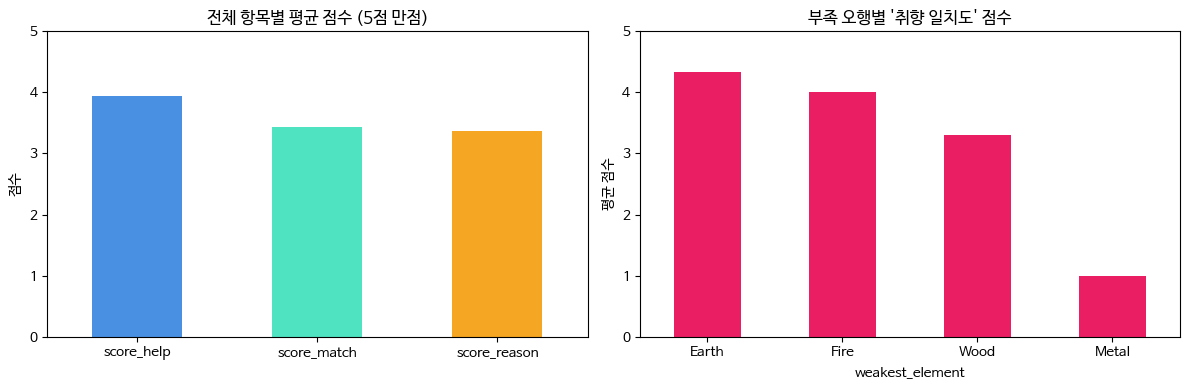

In [2]:
# =========================================================
# Fate Scent - 로그 + 설문 분석 (구글코랩 완성형)
# =========================================================

import pandas as pd
import numpy as np
import datetime
import os
import re

# =========================================================
# 0) 코랩 한글 폰트 설치 및 설정 (강제 인식 업데이트)
# =========================================================
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

print("⏳ 한글 폰트 설치 중... (약 10초 소요)")
os.system('apt-get -qq -y install fonts-nanum')

# 💡 핵심: 설치된 폰트 경로를 직접 찾아 맷플롯립에 강제로 먹여주기 (런타임 재시작 방지)
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rc('font', family='NanumBarunGothic')
else:
    print("⚠️ 폰트 경로를 찾을 수 없습니다. 상단 메뉴 [런타임] -> [세션 다시 시작]을 눌러주세요.")

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
print("✅ 폰트 설정 완료!\n")

# ---------------------------------------------------------
# 0-1) 파일 경로 설정 (코랩 파일 탭에 업로드된 파일명 기준)
# ---------------------------------------------------------
# ⚠️ 업로드한 파일명에 맞게 아래 이름을 꼭 확인해 주세요!
LOG_PATH = "/recommendation_logs (3).csv"
SURVEY_PATH = "/설문조사(1차 16명).xlsx"

# 결과 저장 파일명
OUT_MERGED = "/content/merged_survey_logs.csv"
OUT_SUMMARY = "/content/analysis_summary.xlsx"

# ---------------------------------------------------------
# 1) 파일 불러오기
# ---------------------------------------------------------
print("📂 파일 존재 확인")
print(" - 로그:", os.path.exists(LOG_PATH), LOG_PATH)
print(" - 설문:", os.path.exists(SURVEY_PATH), SURVEY_PATH)

if not os.path.exists(LOG_PATH) or not os.path.exists(SURVEY_PATH):
    raise FileNotFoundError("❌ 파일을 찾을 수 없습니다. 코랩 왼쪽 폴더 아이콘을 눌러 파일을 업로드했는지 확인해주세요!")

logs = pd.read_csv(LOG_PATH, encoding="utf-8-sig")
xls = pd.ExcelFile(SURVEY_PATH)

# 첫 번째 시트 사용
survey = pd.read_excel(SURVEY_PATH, sheet_name=xls.sheet_names[0])

print("\n[데이터 크기]")
print(" - 로그:", logs.shape)
print(" - 설문:", survey.shape)

# ---------------------------------------------------------
# 2) 컬럼 이름 정리 (공백/개행 제거)
# ---------------------------------------------------------
logs.columns = [str(c).strip().replace("\n", " ") for c in logs.columns]
survey.columns = [str(c).strip().replace("\n", " ") for c in survey.columns]

# 설문 컬럼 자동 찾기 (엑셀마다 컬럼명이 조금씩 다를 수 있어서)
def find_col(cols, keywords):
    for c in cols:
        c_norm = str(c).replace(" ", "")
        for kw in keywords:
            if kw.replace(" ", "") in c_norm:
                return c
    return None

# 설문 핵심 컬럼 매핑
COL_NAME = find_col(survey.columns, ["이름또는닉네임", "닉네임"])
COL_BIRTH = find_col(survey.columns, ["생년월일"])
COL_TIME = find_col(survey.columns, ["출생시간"])
COL_HELP = find_col(survey.columns, ["오행차트", "사주풀이", "도움"])
COL_MATCH = find_col(survey.columns, ["평소취향", "일치"])
COL_REASON = find_col(survey.columns, ["추천이유", "납득"])

# 필수 컬럼 체크
required_cols = [COL_NAME, COL_BIRTH, COL_TIME]
if any(c is None for c in required_cols):
    raise ValueError("❌ 설문 필수 컬럼(이름/생년월일/출생시간) 자동 인식 실패. 엑셀의 컬럼명을 확인해주세요.")

# ---------------------------------------------------------
# 3) 로그 데이터 전처리
# ---------------------------------------------------------
for c in ["user_name", "birth_date", "birth_time_range", "timestamp", "pref_tags", "dislike_tags",
          "perfume_name", "brand", "fill_keywords", "fill_keywords_ko", "strongest_element", "weakest_element"]:
    if c in logs.columns:
        logs[c] = logs[c].fillna("").astype(str).str.strip()

logs["birth_date_parsed"] = pd.to_datetime(logs["birth_date"], errors="coerce").dt.date
logs["timestamp_parsed"] = pd.to_datetime(logs["timestamp"], errors="coerce")

for c in ["rank", "rec_score", "fill_percent"]:
    if c in logs.columns:
        logs[c] = pd.to_numeric(logs[c], errors="coerce")

logs = logs.dropna(subset=["birth_date_parsed", "timestamp_parsed", "rank"]).copy()
logs = logs.sort_values(["user_name", "birth_date_parsed", "birth_time_range", "timestamp_parsed", "rank"])

# ---------------------------------------------------------
# 4) 설문 데이터 전처리
# ---------------------------------------------------------
survey = survey.copy()
survey["user_name"] = survey[COL_NAME].fillna("").astype(str).str.strip()
survey["birth_date_parsed"] = pd.to_datetime(survey[COL_BIRTH], errors="coerce").dt.date

def convert_time_to_range(v):
    if pd.isna(v): return np.nan
    if isinstance(v, datetime.time):
        h = v.hour
        return f"{h:02d}~{(h+1)%24:02d}"
    s = str(v).strip()
    if not s: return np.nan
    t = pd.to_datetime(s, errors="coerce")
    if pd.notna(t):
        h = t.hour
        return f"{h:02d}~{(h+1)%24:02d}"
    m = re.search(r"(\d{1,2})", s)
    if m:
        h = int(m.group(1))
        if 0 <= h <= 23:
            return f"{h:02d}~{(h+1)%24:02d}"
    return np.nan

survey["birth_time_range"] = survey[COL_TIME].apply(convert_time_to_range)

score_cols = [COL_HELP, COL_MATCH, COL_REASON]
for c in score_cols:
    if c is not None and c in survey.columns:
        survey[c] = pd.to_numeric(survey[c], errors="coerce")

# ---------------------------------------------------------
# 5) 로그를 '세션 단위'로 요약 (Top3 묶기)
# ---------------------------------------------------------
logs["is_session_start"] = (logs["rank"] == 1).astype(int)
logs["session_no"] = logs.groupby(["user_name", "birth_date_parsed", "birth_time_range"])["is_session_start"].cumsum()
logs["session_key"] = (logs["user_name"] + "|" + logs["birth_date_parsed"].astype(str) + "|" + logs["birth_time_range"].astype(str) + "|" + logs["session_no"].astype(str))

top3_logs = logs[logs["rank"].isin([1,2,3])].copy()
top3_logs = top3_logs.sort_values(["session_key", "rank"])

session_df = (
    top3_logs.groupby(["session_key", "user_name", "birth_date_parsed", "birth_time_range"], as_index=False).agg(
        timestamp=("timestamp", "first"),
        season=("season", "first"),
        strongest_element=("strongest_element", "first"),
        weakest_element=("weakest_element", "first"),
        pref_tags=("pref_tags", "first"),
        dislike_tags=("dislike_tags", "first"),
        top1_perfume=("perfume_name", lambda x: x.iloc[0] if len(x)>0 else ""),
        top1_brand=("brand", lambda x: x.iloc[0] if len(x)>0 else ""),
        top1_score=("rec_score", lambda x: pd.to_numeric(x, errors="coerce").iloc[0] if len(x)>0 else np.nan),
        mean_top3_score=("rec_score", lambda x: pd.to_numeric(x, errors="coerce").mean()),
        avg_fill_percent=("fill_percent", lambda x: pd.to_numeric(x, errors="coerce").mean()),
        has_fill_keywords=("fill_keywords_ko", lambda x: int((x.fillna("").astype(str).str.strip() != "").any()))
    )
)

# ---------------------------------------------------------
# 6) 설문 + 세션 로그 2단계 병합 (이름 -> 생년월일 보정)
# ---------------------------------------------------------
merged = survey.merge(
    session_df.sort_values("timestamp").groupby(["user_name", "birth_date_parsed", "birth_time_range"], as_index=False).tail(1),
    on=["user_name", "birth_date_parsed", "birth_time_range"],
    how="left",
    suffixes=("", "_log")
)

need_fix_idx = merged[merged["session_key"].isna()].index.tolist()
latest_by_birth = session_df.sort_values("timestamp").groupby("birth_date_parsed", as_index=False).tail(1)
birth_count = session_df.groupby("birth_date_parsed")["session_key"].nunique()

for idx in need_fix_idx:
    bd = merged.loc[idx, "birth_date_parsed"]
    if pd.isna(bd): continue
    if (bd in birth_count.index) and (birth_count.loc[bd] == 1):
        row = latest_by_birth[latest_by_birth["birth_date_parsed"] == bd]
        if len(row) == 1:
            row = row.iloc[0]
            for c in ["session_key", "timestamp", "season", "strongest_element", "weakest_element",
                      "pref_tags", "dislike_tags", "top1_perfume", "top1_brand", "top1_score",
                      "mean_top3_score", "avg_fill_percent", "has_fill_keywords"]:
                merged.loc[idx, c] = row[c]

merged["matched"] = merged["session_key"].notna().astype(int)
print(f"✅ 설문-로그 매칭률: {merged['matched'].mean() * 100:.1f}%")

# ---------------------------------------------------------
# 7) 분석용 파생 컬럼 및 점수 컬럼 이름 변경
# ---------------------------------------------------------
rename_map = {}
if COL_HELP: rename_map[COL_HELP] = "score_help"
if COL_MATCH: rename_map[COL_MATCH] = "score_match"
if COL_REASON: rename_map[COL_REASON] = "score_reason"
merged = merged.rename(columns=rename_map)

for c in ["score_help", "score_match", "score_reason", "mean_top3_score", "avg_fill_percent", "top1_score"]:
    if c in merged.columns:
        merged[c] = pd.to_numeric(merged[c], errors="coerce")

# ---------------------------------------------------------
# 8) 기본 분석 결과 출력
# ---------------------------------------------------------
print("\n" + "="*60)
print("📊 [1] 전체 평균 만족도 점수")
print("="*60)
avg_scores = merged[["score_help", "score_match", "score_reason"]].mean()
print(avg_scores)

print("\n" + "="*60)
print("📊 [2] 부족 오행(weakest_element)별 평균 만족도")
print("="*60)
weakest_analysis = (
    merged[merged["matched"] == 1]
    .groupby("weakest_element")[["score_help", "score_match", "score_reason"]]
    .mean()
    .round(2)
    .sort_values("score_match", ascending=False)
)
print(weakest_analysis)

print("\n" + "="*60)
print("📊 [3] 설문 항목 간 상관관계")
print("="*60)
corr_cols = ["score_help", "score_match", "score_reason"]
corr_df = merged[corr_cols].corr().round(2)
print(corr_df)

# ---------------------------------------------------------
# 9) 결과 저장 (CSV + Excel)
# ---------------------------------------------------------
merged.to_csv(OUT_MERGED, index=False, encoding="utf-8-sig")
with pd.ExcelWriter(OUT_SUMMARY, engine="openpyxl") as writer:
    merged.to_excel(writer, sheet_name="merged_data", index=False)
    avg_scores.to_frame("mean_score").to_excel(writer, sheet_name="summary_avg")
    weakest_analysis.to_excel(writer, sheet_name="by_weakest_element")
    corr_df.to_excel(writer, sheet_name="correlation")
print(f"\n✅ 데이터 병합 및 엑셀 리포트 저장 완료: {OUT_SUMMARY}")

# ---------------------------------------------------------
# 10) 시각화 차트 출력
# ---------------------------------------------------------
try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 첫 번째 차트: 전체 평균
    avg_scores.plot(kind="bar", color=['#4A90E2', '#50E3C2', '#F5A623'], ax=axes[0])
    axes[0].set_title("전체 항목별 평균 점수 (5점 만점)", fontweight='bold')
    axes[0].set_ylabel("점수")
    axes[0].set_ylim(0, 5)
    axes[0].tick_params(axis='x', rotation=0)

    # 두 번째 차트: 부족 오행별 취향 일치 점수
    if len(weakest_analysis) > 0:
        weakest_analysis["score_match"].sort_values(ascending=False).plot(kind="bar", color='#E91E63', ax=axes[1])
        axes[1].set_title("부족 오행별 '취향 일치도' 점수", fontweight='bold')
        axes[1].set_ylabel("평균 점수")
        axes[1].set_ylim(0, 5)
        axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("차트 출력 에러:", e)